@author: spe

This example covers calculating the forces in a $F=0\rightarrow F=1$, three-dimensional MOT
in a variety of different ways and comparing the various results.

AttributeError: module 'pylcp' has no attribute 'forceFromBeamsSimple'

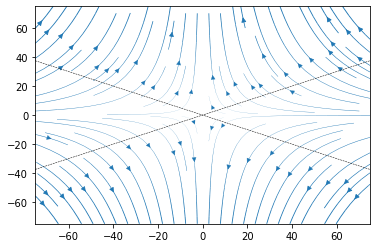

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import pylcp.tools
#plt.style.use('paper')

# Define a coordinate system:
x = np.arange(-75, 75.1, 0.4)
v = np.arange(-20, 20.1, 0.1)

X, V = np.meshgrid(x, v)

# Define the laser and field properties:
det = -3.0
beta = 2.0
alpha = 0.15
nb = 6.0

# Plot up the quadrupole field:
X2, Y2 = np.meshgrid(x, x)
B = pylcp.tools.quadrupoleField3D([X2, np.zeros(X2.shape), Y2], alpha)
Bmag = np.sqrt(sum(B[j]**2 for j in range(len(B))))
plt.figure(3)
plt.clf()
plt.streamplot(X2, Y2, B[0], B[2], linewidth=Bmag/Bmag.max())
plt.plot(x, -0.5*x, 'k--', linewidth=0.5)
plt.plot(x, +0.5*x, 'k--', linewidth=0.5)
plt.ylim((x[0], x[-1]))

# Make the laser beams:
laserBeams = pylcp.tools.standard_six_beam_MOT(beta, det)

# Now let's define some functions that accurately approximate the force along
# certain directions of a MOT.  These "limiting" functions serve as useful
# checks on our more general code.
def dimForce1Dxyz(x, v, delta, beta, alpha, totbeta):
    return beta(x)*\
               (1/(1 + totbeta(x) + 4*(delta - v - alpha*x)**2) - \
                1/(1 + totbeta(x) + 4*(delta + v + alpha*x)**2) )

def dimForce1Dyeqx(r, vr, delta, beta, alpha, totbeta):
    return 2.0/np.sqrt(2.0)*beta(r)*(\
           -0.125*(3.0-2.0*np.sqrt(2.0))\
               *1/(1 + totbeta(r) + 4*(delta + vr/np.sqrt(2) - alpha*r)**2)\
           -0.25\
               *1/(1 + totbeta(r) + 4*(delta + vr/np.sqrt(2))**2)\
           -0.125*(3.0+2.0*np.sqrt(2.0))\
               *1/(1 + totbeta(r) + 4*(delta + vr/np.sqrt(2) + alpha*r)**2)\
           +0.125*(3.0-2.0*np.sqrt(2.0))\
               *1/(1 + totbeta(r) + 4*(delta - vr/np.sqrt(2) + alpha*r)**2)\
           +0.25
               *1/(1 + totbeta(r) + 4*(delta - vr/np.sqrt(2))**2)\
           +0.125*(3.0+2.0*np.sqrt(2.0))\
               *1/(1 + totbeta(r) + 4*(delta - vr/np.sqrt(2) - alpha*r)**2))

# Let's now calcualte the force using the functions above.
Fz = dimForce1Dxyz(X, V, det, lambda x: beta, alpha,
                               lambda x: nb*beta)
Fx = dimForce1Dxyz(X, V, det, lambda x: beta, alpha/2,
                               lambda x: nb*beta)
Fxy = dimForce1Dyeqx(X, V, det, lambda x: beta, alpha/2,
                                 lambda x: nb*beta)


# Now, calculate the force from the beams using the forceFromBeamsSimple
# function, which should simply reproduce what functions above.
Fz2 = pylcp.forceFromBeamsSimple([np.zeros(X.shape), np.zeros(X.shape), X],
                     [np.zeros(V.shape), np.zeros(V.shape), V], laserBeams,
                     lambda R: pylcp.tools.quadrupoleField3D(R, alpha))[2]

Fx2 = pylcp.forceFromBeamsSimple([X, np.zeros(X.shape), np.zeros(X.shape)],
                     [V, np.zeros(V.shape), np.zeros(V.shape)], laserBeams,
                     lambda R: pylcp.tools.quadrupoleField3D(R, alpha))[0]

Fxy2 = pylcp.forceFromBeamsSimple([X, X, np.zeros(X.shape)],
                      [V, V, np.zeros(V.shape)], laserBeams,
                      lambda R: pylcp.tools.quadrupoleField3D(R, alpha))


# Plot it all up:
plt.figure(1,figsize=(6.5, 5.5))
plt.clf()

ax1 = plt.subplot2grid((2, 20), (0, 0), colspan=6)
ax1.tick_params(axis='x', bottom='off', labelbottom='off')
plt.contourf(X, V, Fz)
plt.clim((-0.2, 0.2))
plt.ylabel('$v/v_0$')

ax2 = plt.subplot2grid((2, 20),(0, 6), colspan=6)
ax2.tick_params(axis='y', left='off', labelleft='off')
ax2.tick_params(axis='x', bottom='off', labelbottom='off')
plt.contourf(X, V, Fx)
plt.clim((-0.2, 0.2))

ax3 = plt.subplot2grid((2, 20),(0, 12), colspan=6)
ax3.tick_params(axis='y', left='off', labelleft='off')
ax3.tick_params(axis='x', bottom='off', labelbottom='off')
plt.contourf(X, V, Fxy)
plt.clim((-0.2, 0.2))

ax4 = plt.subplot2grid((2, 20),(0, 19), rowspan=2)
cb1 = plt.colorbar(cax=ax4)
cb1.set_label('$a/a_0$')
plt.subplots_adjust(left=0.10,right=0.9)

ax5 = plt.subplot2grid((2,20),(1,0),colspan=6)
plt.contourf(X, V, Fz2)
plt.ylabel('$v/v_0$')
plt.xlabel('$z/(v_0^2/a_0)$')

ax6 = plt.subplot2grid((2,20),(1,6),colspan=6)
ax6.tick_params(axis='y',left='off',labelleft='off')
plt.contourf(X, V, Fx2)
plt.xlabel('$x/(v_0^2/a_0)$')

ax7 = plt.subplot2grid((2,20),(1,12),colspan=6)
ax7.tick_params(axis='y',left='off',labelleft='off')
plt.contourf(np.sqrt(2)*X,np.sqrt(2)*V,1/np.sqrt(2)*(Fxy2[0] + Fxy2[1]))

plt.xlim((x[0], x[-1]))
plt.ylim((v[0], v[-1]))
plt.xlabel('$\sqrt{2}(x\hat{x} + y\hat{y})/(v_0^2/a_0)$')

plt.subplots_adjust(left=0.10, right=0.9)
